<a href="https://colab.research.google.com/github/asgharlaib/Project_v1/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install --upgrade adapt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 43.9 MB/s eta 0:00:00
  Created wheel for adapt: filename=adapt-0.4.4-py3-none-any.whl size=131790 sha256=12c0bf852684ff305e8677ec1ed0f1be6b86c41f575e39cb36ef16bfc0a34fcf
  Stored in directory: /root/.cache/pip/wheels/cb/88/91/f7ac7b6024ad8778b5ecca6ebe44421105722648f2a6b7afd7
Successfully built adapt
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [2]:
pip install keras --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1


In [3]:
!pip install prophet

In [4]:
#Importing necessary libraries
import pandas as pd
import scikeras
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.model_selection import GridSearchCV
from prophet import Prophet
from scikeras.wrappers import KerasRegressor
import os
from statsmodels.tsa.arima_model import ARIMA

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#reading the dataset
full_df = pd.read_csv("/content/drive/MyDrive/LCL-June2015v2_134.csv")
full_df.head(n=10)

,LCLid,stdorToU,DateTime,KWH/hh (per half hour)
0,MAC005555,Std,2012-06-15 03:30:00.0000000,0.118
1,MAC005555,Std,2012-06-15 04:00:00.0000000,0.078
2,MAC005555,Std,2012-06-15 04:30:00.0000000,0.091
3,MAC005555,Std,2012-06-15 05:00:00.0000000,0.068
4,MAC005555,Std,2012-06-15 05:30:00.0000000,0.092
5,MAC005555,Std,2012-06-15 06:00:00.0000000,0.194
6,MAC005555,Std,2012-06-15 06:30:00.0000000,0.091
7,MAC005555,Std,2012-06-15 07:00:00.0000000,0.069
8,MAC005555,Std,2012-06-15 07:30:00.0000000,0.088
9,MAC005555,Std,2012-06-15 08:00:00.0000000,0.087


In [7]:
#Making copy of origonal dataset
full_df_copy = full_df.copy()

In [8]:
#Looking for columns' datatypes
print(f"full_df columns datatypes: {full_df.dtypes} \n")

full_df columns datatypes: LCLid                      object
stdorToU                   object
DateTime                   object
KWH/hh (per half hour)     object
dtype: object 



In [9]:
# Convert the 'DateTime' column to datetime type
full_df['DateTime'] = pd.to_datetime(full_df['DateTime'])


# Extract the date and time into separate columns
full_df['Date'] = full_df['DateTime'].dt.date
full_df['Time'] = full_df['DateTime'].dt.time


# Display the first few rows to verify
print(full_df.head())

       LCLid stdorToU            DateTime KWH/hh (per half hour)         Date  \
0  MAC005555      Std 2012-06-15 03:30:00                  0.118   2012-06-15   
1  MAC005555      Std 2012-06-15 04:00:00                  0.078   2012-06-15   
2  MAC005555      Std 2012-06-15 04:30:00                  0.091   2012-06-15   
3  MAC005555      Std 2012-06-15 05:00:00                  0.068   2012-06-15   
4  MAC005555      Std 2012-06-15 05:30:00                  0.092   2012-06-15   

       Time  
0  03:30:00  
1  04:00:00  
2  04:30:00  
3  05:00:00  
4  05:30:00  


In [10]:
full_df.set_index('DateTime', inplace=True)

In [11]:
#Converting consumption column to numeric datatype
full_df['KWH/hh (per half hour) '] = pd.to_numeric(full_df['KWH/hh (per half hour) '], errors='coerce')
full_df.columns

Index(['LCLid', 'stdorToU', 'KWH/hh (per half hour) ', 'Date', 'Time'], dtype='object')

In [12]:
#Pre-processing for creating daily dataframe
full_df_daily = full_df.groupby(['Date', 'stdorToU', 'LCLid']).agg({'KWH/hh (per half hour) ': 'mean'}).reset_index()
full_df_daily.rename(columns={'KWH/hh (per half hour) ': 'Average KWH'}, inplace=True)
full_df_daily.head(20)

,Date,stdorToU,LCLid,Average KWH
0,2011-11-23,ToU,MAC000146,0.187300
1,2011-11-24,ToU,MAC000146,0.178417
2,2011-11-25,ToU,MAC000146,0.140479
3,2011-11-26,ToU,MAC000146,0.125604
4,2011-11-27,ToU,MAC000146,0.119583
5,2011-11-28,ToU,MAC000146,0.127000
6,2011-11-29,ToU,MAC000146,0.148354
7,2011-11-30,ToU,MAC000146,0.137750
8,2011-12-01,ToU,MAC000146,0.125042
9,2011-12-02,ToU,MAC000146,0.110604


In [13]:
##Descriptive Analysis
#Dataframe column names
print(f"Column names: {list(full_df_daily.columns)} \n")

#Dataframe shape
print(f"full_df_daily shape: {full_df_daily.shape} \n")

#Dataframe datatypes
print(f"full_df_daily columns datatypes: {full_df_daily.dtypes} \n")

#Looking for missing values
print(f"missing values: {full_df_daily.isnull().sum()} \n")

Column names: ['Date', 'stdorToU', 'LCLid', 'Average KWH'] 

full_df_daily shape: (20876, 4) 

full_df_daily columns datatypes: Date            object
stdorToU        object
LCLid           object
Average KWH    float64
dtype: object 

missing values: Date           0
stdorToU       0
LCLid          0
Average KWH    5
dtype: int64 



In [14]:
#Locating nan indices
nan_indices = full_df_daily[full_df_daily['Average KWH'].isnull()].index
print(nan_indices)

Index([9038, 9039, 9040, 9041, 9044], dtype='int64')


In [15]:
#Dealing with nan values
full_df_daily['Average KWH'].fillna(full_df_daily['Average KWH'].mean(skipna=True), inplace=True)
full_df_daily.head(15)

,Date,stdorToU,LCLid,Average KWH
0,2011-11-23,ToU,MAC000146,0.187300
1,2011-11-24,ToU,MAC000146,0.178417
2,2011-11-25,ToU,MAC000146,0.140479
3,2011-11-26,ToU,MAC000146,0.125604
4,2011-11-27,ToU,MAC000146,0.119583
5,2011-11-28,ToU,MAC000146,0.127000
6,2011-11-29,ToU,MAC000146,0.148354
7,2011-11-30,ToU,MAC000146,0.137750
8,2011-12-01,ToU,MAC000146,0.125042
9,2011-12-02,ToU,MAC000146,0.110604


In [16]:
#Looking for missing values
print(f"missing values: {full_df_daily.isnull().sum()} \n")

missing values: Date           0
stdorToU       0
LCLid          0
Average KWH    0
dtype: int64 



In [17]:
##Descriptive Statistics
full_df_daily.describe()

,Average KWH
count,20876.000000
mean,0.217520
std,0.139705
min,0.000000
25%,0.112432
50%,0.179531
75%,0.291630
max,1.391292


In [18]:
quantile1 = full_df_daily['Average KWH'].quantile(0.25)
quantile3 = full_df_daily['Average KWH'].quantile(0.75)
Inter_quartile_range = quantile3 - quantile1
lower_bound = quantile1 - 1.5 * Inter_quartile_range
upper_bound = quantile3 + 1.5 * Inter_quartile_range

In [19]:
filtered_data = full_df_daily[(full_df_daily['Average KWH'] >= lower_bound) &
                              (full_df_daily['Average KWH'] <= upper_bound)]
filtered_data.head(10)

,Date,stdorToU,LCLid,Average KWH
0,2011-11-23,ToU,MAC000146,0.187300
1,2011-11-24,ToU,MAC000146,0.178417
2,2011-11-25,ToU,MAC000146,0.140479
3,2011-11-26,ToU,MAC000146,0.125604
4,2011-11-27,ToU,MAC000146,0.119583
5,2011-11-28,ToU,MAC000146,0.127000
6,2011-11-29,ToU,MAC000146,0.148354
7,2011-11-30,ToU,MAC000146,0.137750
8,2011-12-01,ToU,MAC000146,0.125042
9,2011-12-02,ToU,MAC000146,0.110604


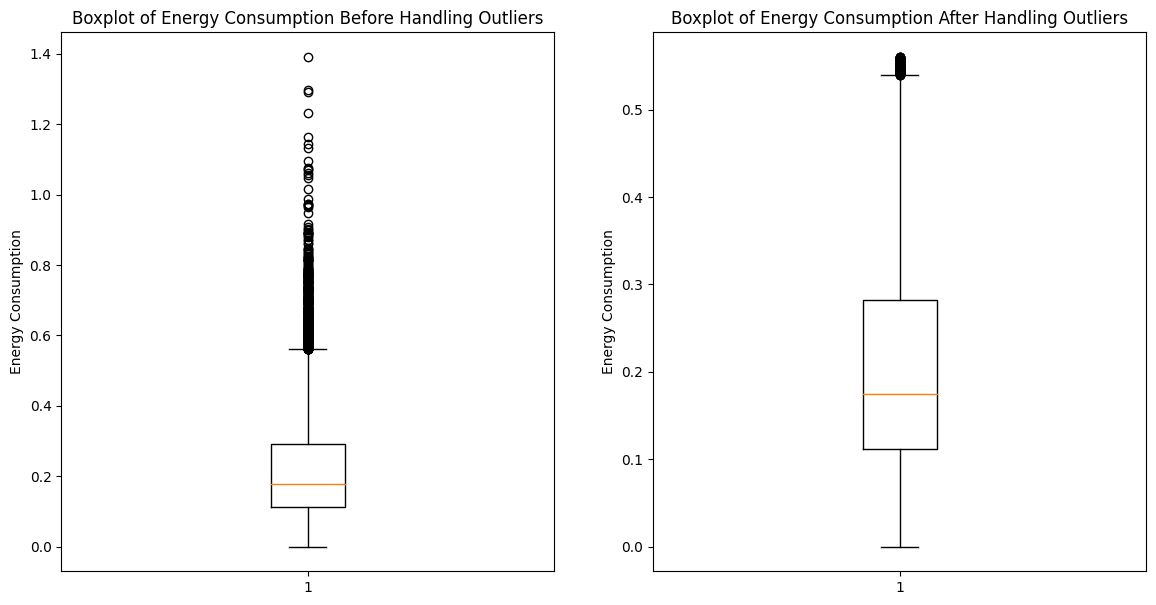

In [20]:
plt.figure(figsize=(14, 7))

plt.subplot(1,2,1)
plt.boxplot(full_df_daily['Average KWH'])
plt.title('Boxplot of Energy Consumption Before Handling Outliers')
plt.ylabel('Energy Consumption')
plt.savefig('Outliers_Boxplot before.png')

plt.subplot(1,2,2)
plt.boxplot(filtered_data['Average KWH'])
plt.title('Boxplot of Energy Consumption After Handling Outliers')
plt.ylabel('Energy Consumption')
plt.savefig('Outliers_Subplot after.png')
plt.show()



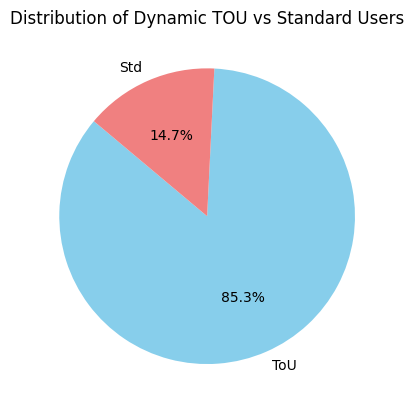

In [21]:
# Count the occurrences of each category
counts = filtered_data['stdorToU'].value_counts()

# Plot a pie chart
plt.figure()
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightcoral'])
plt.title('Distribution of Dynamic TOU vs Standard Users')
plt.show()


            Date stdorToU      LCLid  Average KWH
3005  2012-04-24      Std  MAC005561     0.208625
3028  2012-04-25      Std  MAC005561     0.047000
3293  2012-05-07      Std  MAC005562     0.192149
3316  2012-05-08      Std  MAC005562     0.169229
3339  2012-05-09      Std  MAC005562     0.137375
         Date stdorToU      LCLid  Average KWH
0  2011-11-23      ToU  MAC000146     0.187300
1  2011-11-24      ToU  MAC000146     0.178417
2  2011-11-25      ToU  MAC000146     0.140479
3  2011-11-26      ToU  MAC000146     0.125604
4  2011-11-27      ToU  MAC000146     0.119583


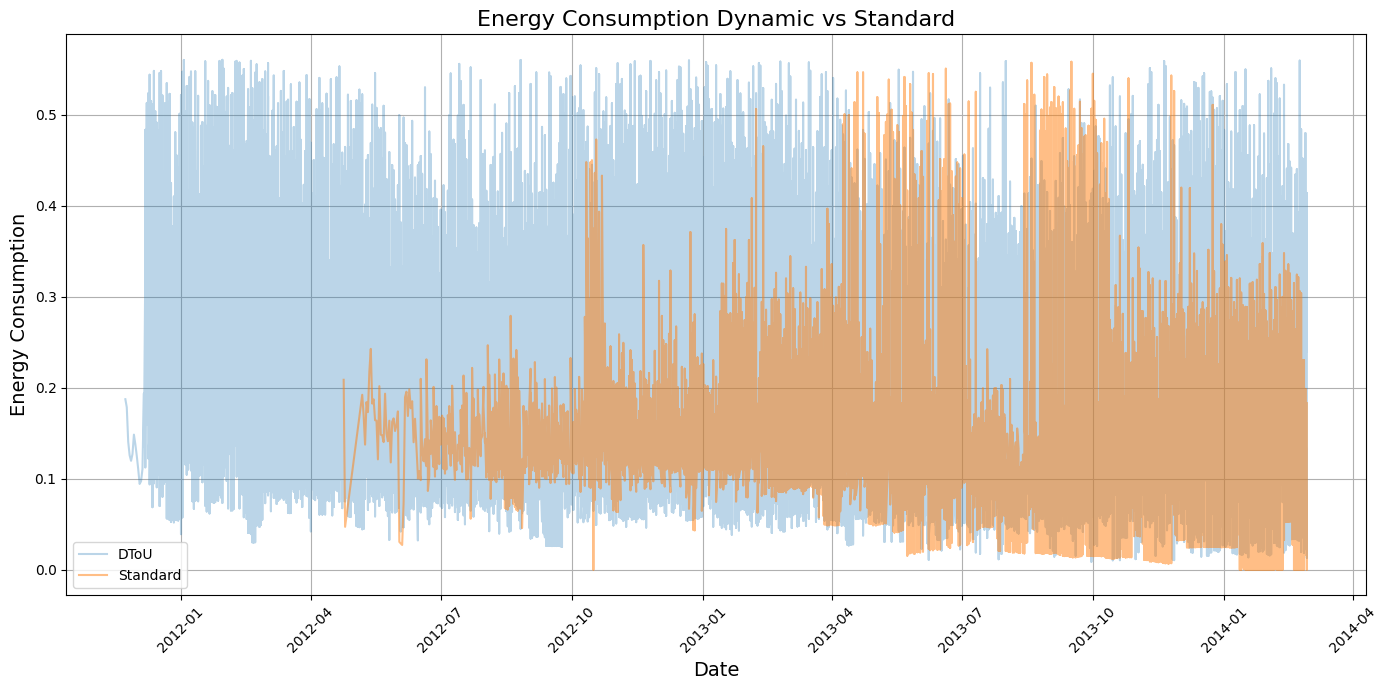

In [22]:
# Filter for dynamic and standard pricing
df_standard = filtered_data[filtered_data['stdorToU'] == 'Std']
df_dynamic = filtered_data[filtered_data['stdorToU'] == 'ToU']

print(df_standard.head())
print(df_dynamic.head())
# Plot the data
plt.figure(figsize=(14, 7))
#plt.hist(df_dynamic['KWH/hh (per half hour) '], bins=20, alpha=0.5, color = 'b', label='Dynamic')
#plt.hist(df_standard['KWH/hh (per half hour) '], bins=20, alpha=0.5, color = 'r', label='Standard')
plt.plot(df_dynamic['Date'], df_dynamic['Average KWH'], alpha = 0.3, label='DToU')
plt.plot(df_standard['Date'], df_standard['Average KWH'],alpha = 0.5, label='Standard')
# Formatting the plot
plt.title('Energy Consumption Dynamic vs Standard', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Energy Consumption', fontsize=14)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [23]:
# Check for NaNs in the input data for the standard users
if df_standard.isnull().values.any():
    print("NaN values found in the input data for standard users.")
else:
    print("No NaN values in the input data for standard users.")


No NaN values in the input data for standard users.


In [26]:
def preprocess_data(df, time_step):
    data = df['Average KWH'].values
    dates = df['Date'].values  # Using 'Date' column
    data = data.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)

    X, y, datestamps = [], [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
        datestamps.append(dates[i + time_step])  # Store corresponding date
    X = np.array(X)
    y = np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    datestamps = np.array(datestamps)  # Convert list to numpy array
    return X, y, scaler, datestamps


In [27]:
# Preprocess the data
time_step = 8  # number of previous timesteps to use for prediction
X_dynamic, y_dynamic, scaler_dynamic, date_stamps_dynamic = preprocess_data(df_dynamic, time_step)
X_standard, y_standard, scaler_standard, date_stamps_standard = preprocess_data(df_standard, time_step)

# Split the data into training and testing sets
X_train_dyn, X_test_dyn, y_train_dyn, y_test_dyn = train_test_split(X_dynamic, y_dynamic, test_size=0.2, random_state=42)
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_standard, y_standard, test_size=0.2, random_state=42)

In [28]:
# Build LSTM model
def build_lstm_model(input_shape, units=50, dropout_rate=0.2, learning_rate=0.001):
    print(f"Building LSTM model with input shape: {input_shape}")
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model


In [29]:
# Train the LSTM model for dynamic users
model_dynamic = build_lstm_model(input_shape=(X_train_dyn.shape[1], X_train_dyn.shape[2]))
history_dynamic = model_dynamic.fit(X_train_dyn, y_train_dyn, epochs=20, batch_size=32, validation_data=(X_test_dyn, y_test_dyn), verbose=1)


Building LSTM model with input shape: (8, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - loss: 0.0556 - val_loss: 0.0455
Epoch 2/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0470 - val_loss: 0.0451
Epoch 3/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0457 - val_loss: 0.0455
Epoch 4/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0448 - val_loss: 0.0437
Epoch 5/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0432 - val_loss: 0.0419
Epoch 6/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0426 - val_loss: 0.0421
Epoch 7/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0420 - val_loss: 0.0440
Epoch 8/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0422 - val_loss: 0.0417
Epoch 9/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0408 - val_loss: 0.0411
Epoch 10/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0416 - val_loss: 0.0409
Epoch 11/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0419 - val_loss: 0.0402
Epoch 12/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms

In [30]:
# Train the LSTM model for standard users
model_standard = build_lstm_model(input_shape=(X_train_std.shape[1], X_train_std.shape[2]))
history_standard = model_standard.fit(X_train_std, y_train_std, epochs=20, batch_size=32, validation_data=(X_test_std, y_test_std), verbose=1)


Building LSTM model with input shape: (8, 1)
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0502 - val_loss: 0.0289
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0345 - val_loss: 0.0284
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0296 - val_loss: 0.0274
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0316 - val_loss: 0.0226
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0260 - val_loss: 0.0215
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0228 - val_loss: 0.0205
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0211 - val_loss: 0.0201
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0214 - val_loss: 0.0203
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0207 - val_loss: 0.0200
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0208 - val_loss: 0.0197
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0212 - val_loss: 0.0192
Epoch 12/20
75/75 ━━━━━━━━━━

In [31]:
# Predict consumption for dynamic users
pred_dynamic = model_dynamic.predict(X_test_dyn)

# Predict consumption for standard users
pred_standard = model_standard.predict(X_test_std)

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [32]:
# Check for NaNs in the predictions
if np.any(np.isnan(pred_standard)):
    print("NaN values found in standard TOU predictions.")
else:
    print("No NaN values in standard TOU predictions.")


No NaN values in standard TOU predictions.


In [33]:
# Inverse transform the predictions for dynamic users
pred_dynamic = scaler_dynamic.inverse_transform(pred_dynamic)
y_test_dyn_inverse = scaler_dynamic.inverse_transform(y_test_dyn.reshape(-1, 1))

# Inverse transform the predictions for standard users
pred_standard = scaler_standard.inverse_transform(pred_standard)
y_test_std_inverse = scaler_standard.inverse_transform(y_test_std.reshape(-1, 1))

In [34]:
# Find peak consumption values for dynamic users
peak_dynamic_value = max(pred_dynamic)
peak_dynamic_time = y_test_dyn_inverse[np.argmax(pred_dynamic)]

# Find peak consumption values for standard users
peak_standard_value = max(pred_standard)
peak_standard_time = y_test_std_inverse[np.argmax(pred_standard)]


In [35]:
print(f"Peak Dynamic TOU Consumption Value: {peak_dynamic_value}")
print(f"Corresponding Actual Dynamic TOU Consumption Value: {peak_dynamic_time}")

print(f"Peak Standard Consumption Value: {peak_standard_value}")
print(f"Corresponding Actual Standard TOU Consumption Value: {peak_standard_time}")


Peak Dynamic TOU Consumption Value: [0.45124635]
Corresponding Actual Dynamic TOU Consumption Value: [0.377875]
Peak Standard Consumption Value: [0.3800777]
Corresponding Actual Standard TOU Consumption Value: [0.09833333]


In [36]:
# Calculate MAE for dynamic users
mae_dynamic = mean_absolute_error(y_test_dyn_inverse, pred_dynamic)
print(f"Dynamic TOU MAE: {mae_dynamic}")

# Calculate MAE for standard users
mae_standard = mean_absolute_error(y_test_std_inverse, pred_standard)
print(f"Standard TOU MAE: {mae_standard}")


Dynamic TOU MAE: 0.0769902956478953
Standard TOU MAE: 0.052968570255068174


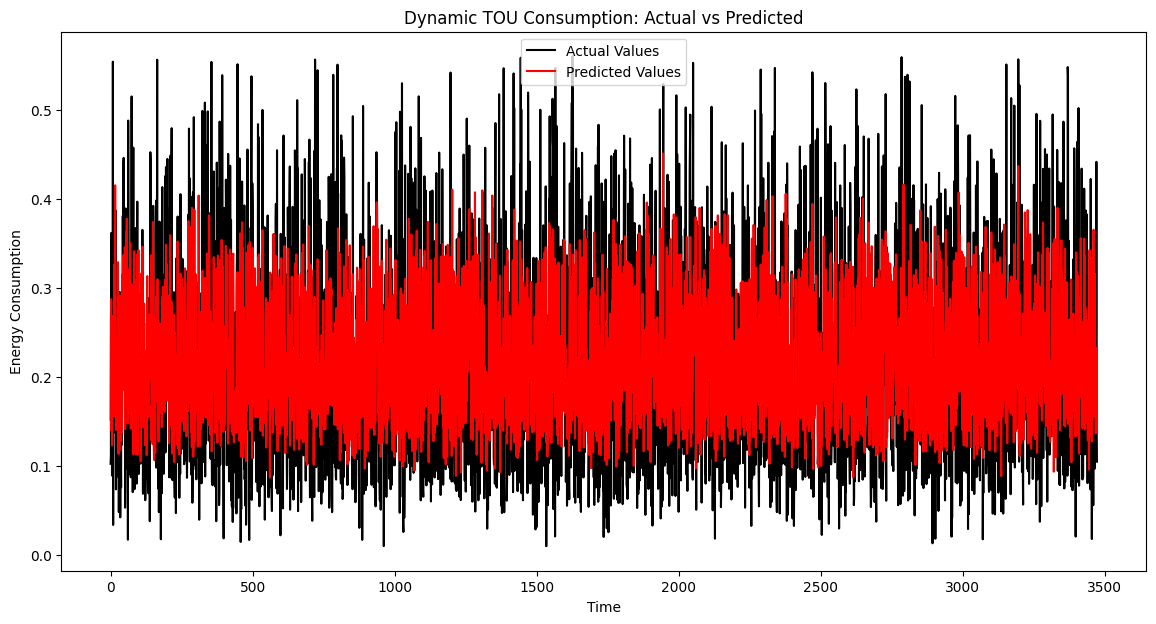

In [37]:
# Plot the predictions vs actual values for dynamic TOU users
plt.figure(figsize=(14, 7))
plt.plot(y_test_dyn_inverse, color='black', label='Actual Values')
plt.plot(pred_dynamic, color='red', label='Predicted Values')
plt.title('Dynamic TOU Consumption: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()




In [38]:
model = KerasRegressor(build_fn=build_lstm_model, input_shape = (8,1), epochs=1, batch_size=32, verbose=0, dropout_rate=0.2, learning_rate=0.001, units=50)

In [39]:
param_grid = {
    'units': [50, 100],
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.001, 0.01],
    'batch_size': [32, 64],
    'epochs': [10, 20]
}

from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_result = grid.fit(X_train_dyn, y_train_dyn)

# Print the best parameters and score
print(f"Best parameters found: {grid_result.best_params_}")
print(f"Best score found: {grid_result.best_score_}")


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not

Building LSTM model with input shape: (8, 1)
Best parameters found: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 20, 'learning_rate': 0.01, 'units': 100}
Best score found: -0.027129583747508127


In [40]:
# Build LSTM model
def best_grid_lstm_model(input_shape, units=100, dropout_rate=0.2, learning_rate=0.01):
    print(f"Building LSTM model with input shape: {input_shape}")
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

In [41]:
best_model_dynamic = best_grid_lstm_model(input_shape=(X_train_dyn.shape[1], X_train_dyn.shape[2]))
history_best_dynamic = best_model_dynamic.fit(X_train_dyn, y_train_dyn, epochs=20, batch_size=32, validation_data=(X_test_dyn, y_test_dyn), verbose=1)

Building LSTM model with input shape: (8, 1)
Epoch 1/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0583 - val_loss: 0.0417
Epoch 2/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0424 - val_loss: 0.0399
Epoch 3/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0398 - val_loss: 0.0369
Epoch 4/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0360 - val_loss: 0.0327
Epoch 5/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0345 - val_loss: 0.0321
Epoch 6/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0329 - val_loss: 0.0311
Epoch 7/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0296 - val_loss: 0.0321
Epoch 8/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0300 - val_loss: 0.0305
Epoch 9/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0284 - val_loss: 0.0298
Epoch 10/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0288 - val_loss: 0.0301
Epoch 11/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0273 - val_loss: 0.0290
Epoch 1

In [42]:

best_model_standard = best_grid_lstm_model(input_shape=(X_train_std.shape[1], X_train_std.shape[2]))
history_best_standard = best_model_standard.fit(X_train_std, y_train_std, epochs=20, batch_size=32, validation_data=(X_test_std, y_test_std), verbose=1)

Building LSTM model with input shape: (8, 1)
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0527 - val_loss: 0.0219
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0233 - val_loss: 0.0199
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0229 - val_loss: 0.0207
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0242 - val_loss: 0.0186
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0192 - val_loss: 0.0188
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0212 - val_loss: 0.0194
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0187 - val_loss: 0.0203
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0204 - val_loss: 0.0181
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0193 - val_loss: 0.0205
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0234 - val_loss: 0.0203
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0182 - val_loss: 0.0177
Epoch 12/20
75/75 ━━━━━━━━

In [43]:
# Predict consumption for dynamic users
pred_dynamic1 = best_model_dynamic.predict(X_test_dyn)

# Predict consumption for standard users
pred_standard1 = best_model_standard.predict(X_test_std)

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [44]:
# Inverse transform the predictions for dynamic users
pred_dynamic1 = scaler_dynamic.inverse_transform(pred_dynamic1)
y_test_dyn_inverse = scaler_dynamic.inverse_transform(y_test_dyn.reshape(-1, 1))

# Inverse transform the predictions for standard users
pred_standard1 = scaler_standard.inverse_transform(pred_standard1)
y_test_std_inverse = scaler_standard.inverse_transform(y_test_std.reshape(-1, 1))

In [45]:
# Calculate MAE for dynamic users
mae_dynamic = mean_absolute_error(y_test_dyn_inverse, pred_dynamic1)
print(f"Dynamic TOU MAE: {mae_dynamic}")

# Calculate MAE for standard users
mae_standard = mean_absolute_error(y_test_std_inverse, pred_standard1)
print(f"Standard TOU MAE: {mae_standard}")


Dynamic TOU MAE: 0.06721239447353516
Standard TOU MAE: 0.0499731445625582


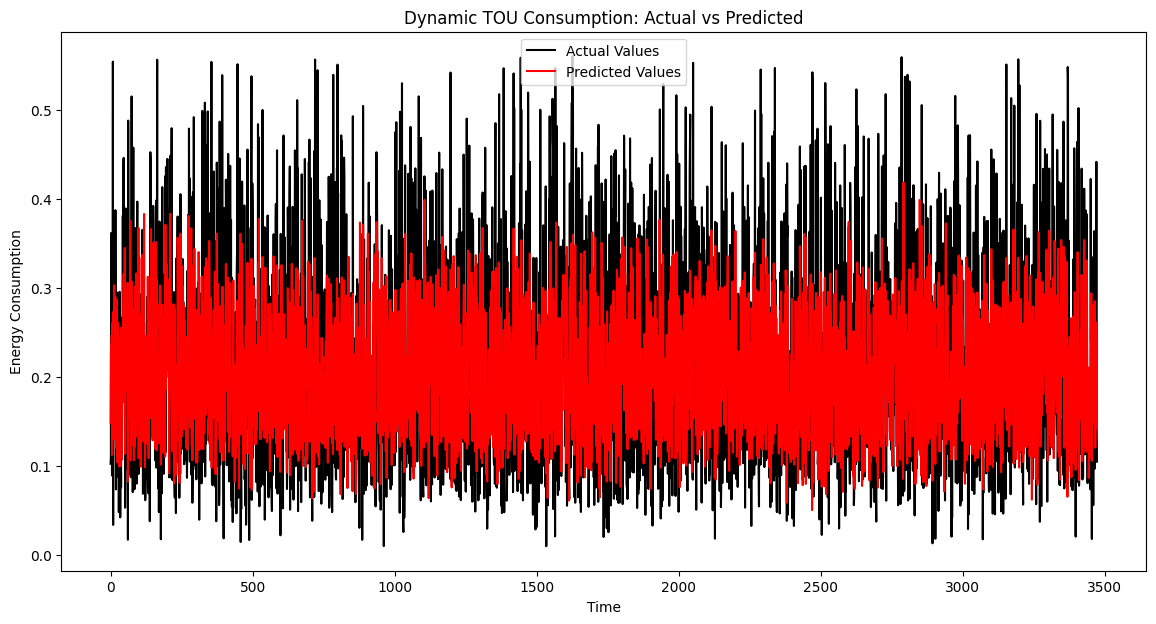

In [46]:
# Plot the predictions vs actual values for dynamic TOU users
plt.figure(figsize=(14, 7))
plt.plot(y_test_dyn_inverse, color='black', label='Actual Values')
plt.plot(pred_dynamic1, color='red', label='Predicted Values')
plt.title('Dynamic TOU Consumption: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()

In [47]:
train_size_dynamic = int(len(df_dynamic) * 0.8)
train_dyn, test_dyn = df_dynamic.iloc[:train_size_dynamic], df_dynamic.iloc[train_size_dynamic:]


In [48]:
train_size_std = int(len(df_standard) * 0.8)
train_std, test_std = df_standard.iloc[:train_size_std], df_standard.iloc[train_size_std:]

In [49]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

energy_values = full_df_daily['KWH/hh (per half hour) '].values
# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(energy_values, lags=100)
plt.title('Autocorrelation Function (ACF)')
plt.show()
plot_pacf(train_values, lags = 40)
plt.title('Dynamic TOU PACF Plot')
plt.show()


KeyError: 'KWH/hh (per half hour) '

In [ ]:
df_dynamic['KWH_diff'] = df_dynamic['KWH/hh (per half hour) '].diff()
df_dynamic.dropna(inplace=True)
df_dynamic.head(5)

In [ ]:
train_size_dynamic = int(len(df_dynamic) * 0.8)
train_dyn, test_dyn = df_dynamic.iloc[:train_size_dynamic], df_dynamic.iloc[train_size_dynamic:]

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

train_values = train_dyn['KWH_diff'].values
# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(train_values, lags=100)
plt.title('Autocorrelation Function (ACF)')
plt.show()
plot_pacf(train_values, lags = 40)
plt.title('Dynamic TOU PACF Plot')
plt.show()

In [ ]:
df_prophet_dynamic = dynamic_df[['Date', 'KWH/hh (per half hour) ']].rename(columns={'Date': 'ds', 'KWH/hh (per half hour) ': 'y'})

In [ ]:
train_size_dynamic = int(len(df_prophet_dynamic) * 0.8)
train_data_dynamic = df_prophet_dynamic[:train_size_dynamic]
test_data_dynamic = df_prophet_dynamic[train_size_dynamic:]

In [ ]:
model_dynamic = Prophet()
model_dynamic.fit(train_data_dynamic)

In [ ]:
future_dynamic = model_dynamic.make_future_dataframe(periods=len(test_data_dynamic), freq='D')  # 'H' for hourly data
forecast_dynamic = model_dynamic.predict(future_dynamic)

In [ ]:
forecast_test_dynamic = forecast_dynamic.iloc[-len(test_data_dynamic):]['yhat']
mse = mean_squared_error(test_data_dynamic['y'], forecast_test_dynamic)
print(f'Mean Squared Error: {mse}')

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(test_data_dynamic['ds'], test_data_dynamic['y'], label='Actual Values')
plt.plot(test_data_dynamic['ds'], forecast_test_dynamic, label='Forecasted Values')
plt.legend(loc='upper left')
plt.title('Dynamic Peak Hour Forecast vs Actual')
plt.show()

In [ ]:
df_prophet_std = standard_df[['Date', 'KWH/hh (per half hour) ']].rename(columns={'Date': 'ds', 'KWH/hh (per half hour) ': 'y'})

In [ ]:
train_size_std = int(len(df_prophet_std) * 0.8)
train_data_std = df_prophet_std[:train_size_std]
test_data_std = df_prophet_std[train_size_std:]
print(test_data_std)

In [ ]:
model_std = Prophet()
model_std.fit(train_data_std)

In [ ]:
test_data_std = test_data_std.dropna(subset=['y'])

In [ ]:
test_data_std['y'].fillna(method='ffill', inplace=True)  # forward fill

In [ ]:
print(test_data_std[test_data_std['y'].isna()])

In [ ]:
future_std = model_std.make_future_dataframe(periods=len(test_data_std), freq='D')  # 'H' for hourly data
forecast_std = model_std.predict(future_std)

In [ ]:
forecast_test_std = forecast_std.iloc[-len(test_data_std):]['yhat']
mse = mean_squared_error(test_data_std['y'], forecast_test_std)
print(f'Mean Squared Error: {mse}')

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(test_data_std['ds'], test_data_std['y'], label='Actual Values')
plt.plot(test_data_std['ds'], forecast_test_std, label='Forecasted Values')
plt.legend(loc='upper left')
plt.title('Standard Peak Hour Forecast vs Actual')
plt.show()

In [ ]:
# Find the maximum predicted consumption
max_predicted_value = forecast_dynamic['yhat'].max()
# Find the maximum predicted consumption
max_predicted_value = forecast_std['yhat'].max()

# Print the results
print(f"The maximum predicted dynamic consumption is {max_predicted_value:.2f} KWH")
print(f"The maximum predicted standard consumption is {max_predicted_value:.2f} KWH")

In [ ]:
import itertools

# Define the parameter grid
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [10.0, 15.0, 20.0],
    'holidays_prior_scale': [0.1, 0.5, 1.0]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# Initialize a DataFrame to store the results
results = []

# Loop over each combination of parameters
for params in all_params:
    # Initialize a Prophet model with the current set of parameters
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale']
    )

     # Fit the model on the training data
    model.fit(train_data_dynamic)

    # Make predictions on the test data
    forecast = model.predict(test_data_dynamic)

    # Calculate the mean squared error of the predictions
    mse = mean_squared_error(test_data_dynamic['y'], forecast['yhat'])

    # Store the parameters and the mse in the results list
    results.append({'params': params, 'mse': mse})

# Convert the results list into a DataFrame
results_df = pd.DataFrame(results)

# Find the parameters with the lowest mse
best_params = results_df.loc[results_df['mse'].idxmin()]

print(f"Best Parameters: {best_params['params']}")
print(f"Best MSE: {best_params['mse']}")

In [ ]:
 Define the parameter grid
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [10.0, 15.0, 20.0],
    'holidays_prior_scale': [0.1, 0.5, 1.0],
    'yearly_seasonality': [True, False]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# Initialize a DataFrame to store the results
results = []

# Loop over each combination of parameters
for params in all_params:
    # Initialize a Prophet model with the current set of parameters
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale'],
        yearly_seasonality=params['yearly_seasonality']

    )

    # Fit the model on the training data
    model.fit(train_data_dynamic, daily_seasonality=True)

    # Make predictions on the test data
    forecast = model.predict(test_data_dynamic)

    # Calculate the mean squared error of the predictions
    mse = mean_squared_error(test_data_dynamic['y'], forecast['yhat'])

    # Store the parameters and the mse in the results list
    results.append({'params': params, 'mse': mse})

# Convert the results list into a DataFrame
results_df = pd.DataFrame(results)

# Find the parameters with the lowest mse
best_params = results_df.loc[results_df['mse'].idxmin()]

print(f"Best Parameters: {best_params['params']}")
print(f"Best MSE: {best_params['mse']}")


In [ ]:
# Using the best parameters to fit the final model
best_model_dynamic = Prophet(
    changepoint_prior_scale=best_params['params']['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['params']['seasonality_prior_scale'],
    holidays_prior_scale=best_params['params']['holidays_prior_scale'],
    yearly_seasonality=best_params['params']['yearly_seasonality']
)

best_model_dynamic.fit(train_data_dynamic)
best_forecast_dynamic = best_model_dynamic.predict(test_data_dynamic)

# Now you can evaluate or visualize the forecast
best_forecast_test_dynamic = best_forecast_dynamic.iloc[-len(test_data_dynamic):]['yhat']
mse = mean_squared_error(test_data_dynamic['y'], best_forecast_test_dynamic)
print(f'Mean Squared Error: {mse}')

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(test_data_dynamic['ds'], test_data_dynamic['y'], label='Actual Values')
plt.plot(test_data_dynamic['ds'], best_forecast_test_dynamic, label='Forecasted Values')
plt.legend(loc='upper left')
plt.title('Dynamic Peak Hour Forecast vs Actual Optimised Model')
plt.show()

In [ ]:
# Using the best parameters to fit the final model
best_model_std = Prophet(
    changepoint_prior_scale=best_params['params']['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['params']['seasonality_prior_scale'],
    holidays_prior_scale=best_params['params']['holidays_prior_scale'],
    yearly_seasonality=best_params['params']['yearly_seasonality']
)

best_model_std.fit(train_data_std)
best_forecast_std = best_model_std.predict(test_data_std)

# Now you can evaluate or visualize the forecast
best_forecast_test_std = best_forecast_std.iloc[-len(test_data_std):]['yhat']
mse = mean_squared_error(test_data_std['y'], best_forecast_test_std)
print(f'Mean Squared Error: {mse}')

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(test_data_std['ds'], test_data_std['y'], label='Actual Values')
plt.plot(test_data_std['ds'], best_forecast_test_std, label='Forecasted Values')
plt.legend(loc='upper left')
plt.title('Standard Peak Hour Forecast vs Actual Optimised Model')
plt.show()

In [ ]:
# Find the maximum predicted consumption
max_predicted_value_std = best_forecast_std['yhat'].max()
max_predicted_value_dynamic = best_forecast_dynamic['yhat'].max()

# Print the results
print(f"The maximum predicted standard consumption is {max_predicted_value_std:.2f} KWH")
print(f"The maximum predicted dynamic consumption is {max_predicted_value_dynamic:.2f} KWH")